In [1]:
import scipy
import matplotlib
import numpy as np
import pandas as pd
import numpy.ma as ma
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from colors import red
from collections import Counter
from sklearn import linear_model
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline  
DEFAULT_DPI = 600
matplotlib.rcParams['figure.figsize'] = (8, 5)

/home/y_rebryk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Dataset

In [2]:
def convert(s):
    d = {"пн": 1, "вт": 2, "ср": 3, "чт": 4, "пт": 5, "сб": 6, "вс": 7, "-": 0, "": 0}
    if s in d.keys():
        return d[s]
    else:
        return float(s)

In [3]:
ncols = 55
data = np.genfromtxt("data/dataset_16_2.dms", 
                     delimiter="\t", 
                     converters=dict(zip(range(ncols), [convert] * ncols)), 
                     invalid_raise=False)

df = pd.DataFrame(data)

## Processing

### NaN values

In [4]:
theshold = 0.70
columns_to_remove = []

for index in range(ncols):
    null_ratio = df.iloc[:, index].isnull().sum() / len(df)
    msg = "Percent of nulls for f{}: {:3.2f}%".format(index, 100 * null_ratio)
    
    if null_ratio:
        if null_ratio > theshold:
            columns_to_remove.append("f{}".format(index))
            
        print(red(msg) if null_ratio > theshold else msg)

Percent of nulls for f0: 100.00%
Percent of nulls for f1: 100.00%
Percent of nulls for f4: 76.51%
Percent of nulls for f8: 81.50%
Percent of nulls for f19: 76.51%
Percent of nulls for f20: 76.51%
Percent of nulls for f21: 76.51%
Percent of nulls for f22: 76.51%
Percent of nulls for f23: 76.51%
Percent of nulls for f24: 76.51%
Percent of nulls for f25: 76.51%
Percent of nulls for f26: 76.51%
Percent of nulls for f27: 85.31%
Percent of nulls for f28: 85.31%
Percent of nulls for f29: 76.51%
Percent of nulls for f30: 76.51%
Percent of nulls for f31: 99.54%
Percent of nulls for f32: 85.78%
Percent of nulls for f33: 85.78%
Percent of nulls for f35: 76.51%
Percent of nulls for f36: 76.51%
Percent of nulls for f37: 76.51%
Percent of nulls for f38: 85.37%
Percent of nulls for f39: 85.37%
Percent of nulls for f40: 85.37%
Percent of nulls for f41: 85.37%
Percent of nulls for f42: 76.51%
Percent of nulls for f43: 76.51%
Percent of nulls for f44: 87.82%
Percent of nulls for f45: 85.31%
Percent of n

In [5]:
df = df.drop(columns_to_remove, axis=1)
df.head()

,f2,f3,f5,f6,f7,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f34,f54
0,1.429627e+09,162.0,25910.0,6.0,13.0,64.0,1.0,1.0,0.0,56.0,56.0,8.0,0.0,33.0,3.0,0.0,2.0
1,1.443636e+09,0.0,6971.0,8.0,10.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0
2,1.443653e+09,0.0,1825.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.405667e+09,439.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,56.0,56.0,0.0,0.0,23.0,0.0,0.0,1.0
4,1.430734e+09,150.0,29562.0,13.0,21.0,17.0,1.0,1.0,0.0,56.0,56.0,45.0,0.0,10.0,38.0,0.0,1.0


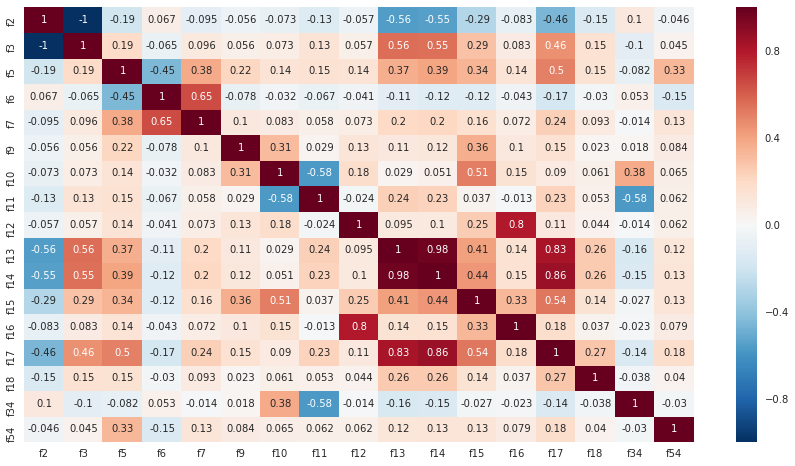

In [6]:
corr = df.corr()

_, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, annot=True, ax=ax)

In [7]:
treshold = 0.8
columns = corr.columns.values

features = set()

for i in range(len(columns)):
    dependent = [j for j in range(i + 1, len(columns)) if corr.iloc[i, j] >= treshold]
    
    if dependent:
        features.add(i)
        
        for it in dependent:
            features.add(it)
        
        print("For {}: {}".format(columns[i], [columns[it] for it in dependent]))

For f12: ['f16']
For f13: ['f14', 'f17']
For f14: ['f17']


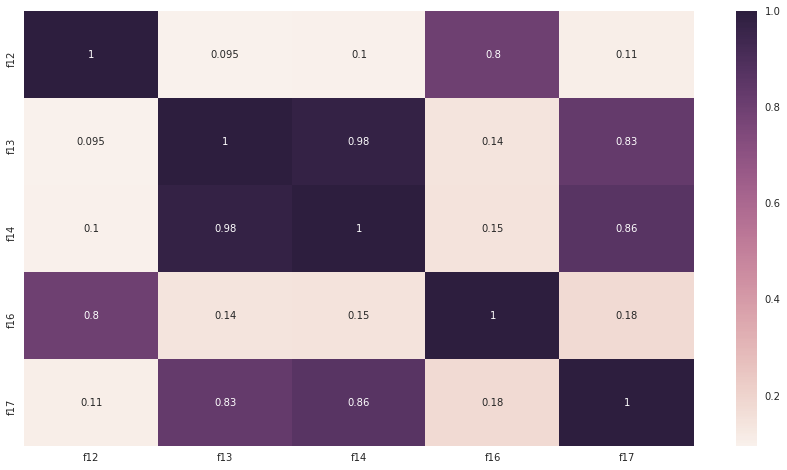

In [8]:
high_corr = corr.iloc[list(features), list(features)]
_, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(high_corr, annot=True, ax=ax)

* We can drop **f12** because it is dependent on **f16**
* We can drop **f13** and **f14** because they are dependent on **f17**.

In [9]:
df = df.drop(["f12", "f13", "f14"], axis=1)
df.head()

,f2,f3,f5,f6,f7,f9,f10,f11,f15,f16,f17,f18,f34,f54
0,1.429627e+09,162.0,25910.0,6.0,13.0,64.0,1.0,1.0,8.0,0.0,33.0,3.0,0.0,2.0
1,1.443636e+09,0.0,6971.0,8.0,10.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0
2,1.443653e+09,0.0,1825.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.405667e+09,439.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,0.0,23.0,0.0,0.0,1.0
4,1.430734e+09,150.0,29562.0,13.0,21.0,17.0,1.0,1.0,45.0,0.0,10.0,38.0,0.0,1.0


### Values distributions

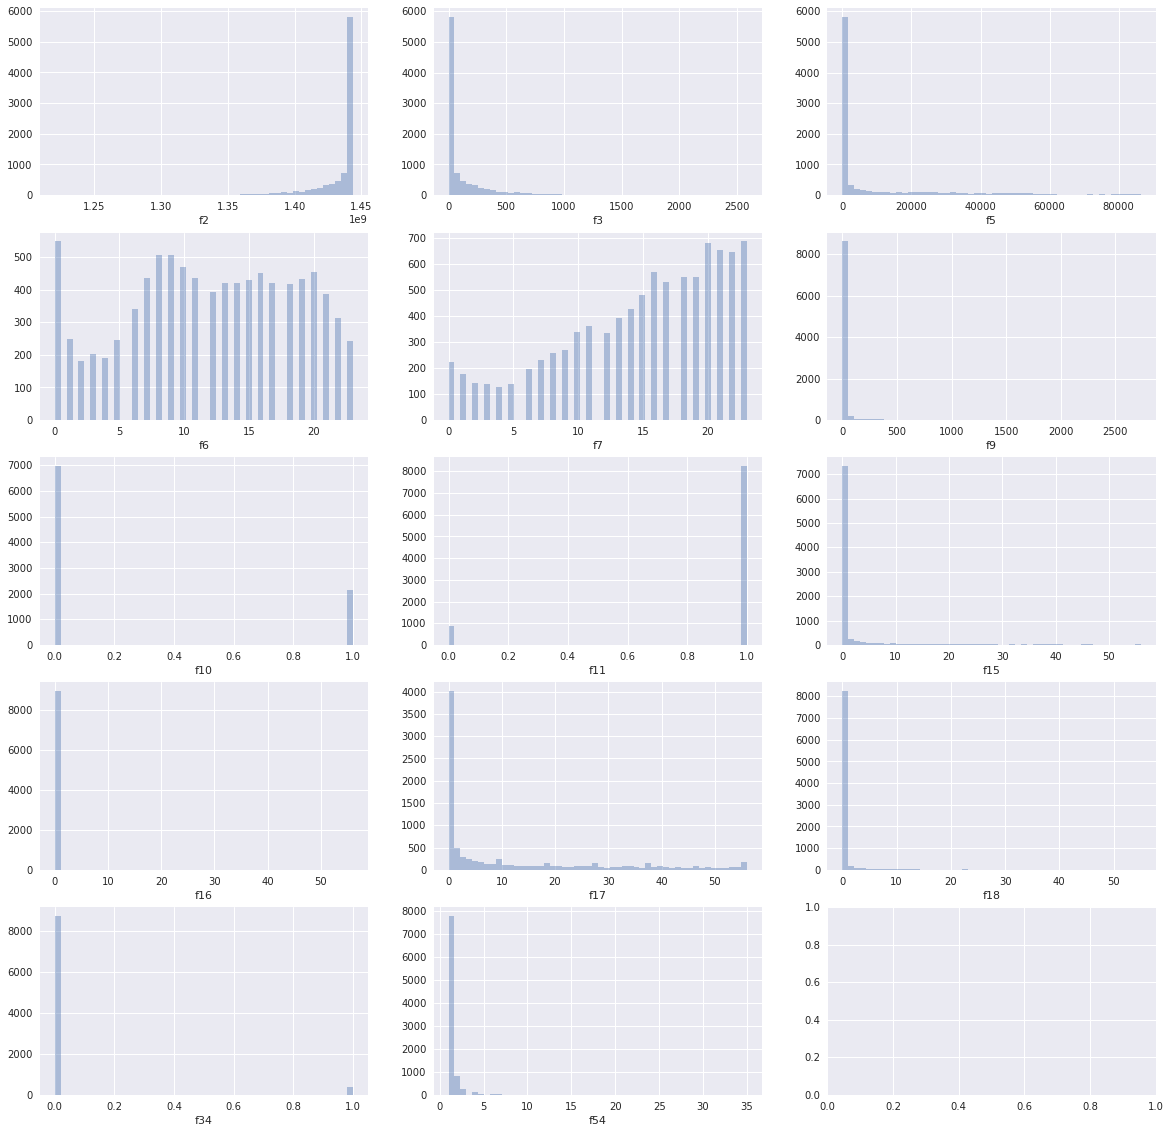

In [16]:
columns = df.columns.values

_, ax = plt.subplots(figsize=(20, 20), nrows=5, ncols=3)

for i in range(len(columns)):
    sns.distplot(df.iloc[:, i].dropna(), bins=50, kde=False, ax=ax[i // 3, i % 3])

### Unique values

In [17]:
for i in range(len(columns)):
    unique_count = len(df.iloc[:, i].unique())
    print("Unique values for {}: {}".format(columns[i], unique_count))

Unique values for f2: 9013
Unique values for f3: 875
Unique values for f5: 4031
Unique values for f6: 24
Unique values for f7: 24
Unique values for f9: 307
Unique values for f10: 2
Unique values for f11: 2
Unique values for f15: 57
Unique values for f16: 54
Unique values for f17: 57
Unique values for f18: 56
Unique values for f34: 2
Unique values for f54: 17


It looks like:
* **f10**, **f11**, **f34** are binary features (also **f12**, but we have already dropped it).
* **f6**, **f7** are categorical features.

## Fraud events

In [18]:
events_count, columns_count = df.shape
abnormality = np.zeros(events_count)
distribution = {column: Counter(df[column]) for column in columns}

In [19]:
for index, row in df.iterrows():
    penalty = 0
    
    for column in columns:
        percent = distribution[column][row[column]] / events_count
        penalty += int(percent < 0.1) + 2 * int(percent < 0.02)
    
    abnormality[index] = penalty

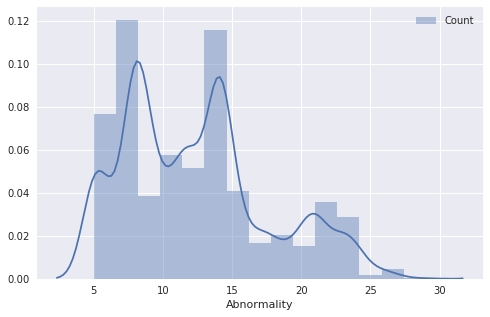

In [20]:
sns.distplot(abnormality, bins=15, axlabel="Abnormality", label="Count")
plt.legend()

Assume, that if abnormality is equal or greater than 25, user is fraud.

In [21]:
np.sum(abnormality >= 25)

97

In [22]:
print(np.mean(abnormality), np.std(abnormality))

12.380826737 5.22689681627


## Clusterization

In [23]:
nclusters = 8

centroid, label = scipy.cluster.vq.kmeans2(df, 
                                           nclusters, 
                                           iter=100, 
                                           thresh=1e-05, 
                                           minit="random", 
                                           missing="warn")

def truevar(x): 
    return np.var(x)


df_abn = pd.DataFrame(abnormality, columns=[["abn"]])
df_label = pd.DataFrame(label, columns=[["cluster_id"]])
cluster_stats = pd.concat([df_abn, df_label], axis=1).pivot_table(
    index="cluster_id",
    values="abn",
    aggfunc=[len, np.mean, np.std, truevar]
)

cluster_stats = cluster_stats.reorder_levels([1,0], axis=1)["abn"]
cluster_stats

/home/y_rebryk/anaconda3/lib/python3.6/site-packages/scipy/cluster/vq.py:660: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


,len,mean,std,truevar
cluster_id,,,,
1,6186.0,10.546880,4.593111,21.093260
3,857.0,16.158693,4.234154,17.907139
4,1320.0,15.961364,4.171552,17.388659
5,474.0,16.537975,4.374106,19.092440
6,57.0,19.157895,3.802206,14.203139
7,202.0,17.450495,4.407143,19.326757


### Calculate variance of abnormality inside clusters

In [24]:
cluster_stats["var_in_cluster"] = cluster_stats["truevar"] * cluster_stats["len"] / sum(cluster_stats["len"])
totvar = np.var(abnormality)
cluster_stats["var_in_cluster_%"] = cluster_stats["var_in_cluster"] / totvar

abn_var_b = 100 * (1 - sum(cluster_stats["var_in_cluster_%"]))
abn_var_inside = 100 * sum(cluster_stats["var_in_cluster_%"])

print("Total abnormality variance: {}".format(totvar))
print("Abnormality variance explained by between-cluster variance: {:.2f}%".format(abn_var_b))
print("Abnormality variance left inside clusters: {:.2f}%".format(abn_var_inside))

cluster_stats

Total abnormality variance: 27.320450327939486
Abnormality variance explained by between-cluster variance: 26.54%
Abnormality variance left inside clusters: 73.46%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
cluster_id,,,,,,
1,6186.0,10.546880,4.593111,21.093260,14.345086,0.525068
3,857.0,16.158693,4.234154,17.907139,1.687161,0.061755
4,1320.0,15.961364,4.171552,17.388659,2.523420,0.092364
5,474.0,16.537975,4.374106,19.092440,0.994923,0.036417
6,57.0,19.157895,3.802206,14.203139,0.089004,0.003258
7,202.0,17.450495,4.407143,19.326757,0.429200,0.015710


In [25]:
def cluster_by(abnormality, column):
    df_abn = pd.DataFrame(abnormality, columns=[["abn"]])
    df_label = pd.DataFrame(df[column], columns=[[column]])

    cluster_stats = pd.concat([df_abn, df_label], axis=1)\
    .pivot_table(
        index=column,
        values="abn",
        aggfunc=[len, np.mean, np.std, truevar]
    )\
    .reorder_levels([1,0], axis=1)["abn"]

    cluster_stats["var_in_cluster"] = cluster_stats["truevar"] * cluster_stats["len"] / sum(cluster_stats["len"])
    cluster_stats["var_in_cluster_%"] = cluster_stats["var_in_cluster"] / totvar

    abn_var_b = 100 * (1 - sum(cluster_stats["var_in_cluster_%"]))
    abn_var_inside = 100 * sum(cluster_stats["var_in_cluster_%"])

    print("Total abnormality variance: {}".format(totvar))
    print("Abnormality variance explained by between-cluster variance: {:.2f}%".format(abn_var_b))
    print("Abnormality variance left inside clusters: {:.2f}%".format(abn_var_inside))

    return cluster_stats 

In [26]:
cluster_by(abnormality, "f6")

Total abnormality variance: 27.320450327939486
Abnormality variance explained by between-cluster variance: 5.71%
Abnormality variance left inside clusters: 94.29%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
f6,,,,,,
0.0,548.0,14.284672,5.572456,30.995604,1.867369,0.068351
1.0,248.0,13.241935,4.657276,21.602758,0.588993,0.021559
2.0,182.0,12.401099,4.292947,18.328131,0.366724,0.013423
3.0,203.0,13.152709,4.772169,22.661409,0.505746,0.018512
4.0,190.0,13.342105,5.203155,26.930332,0.562529,0.020590
5.0,246.0,13.825203,5.110806,26.014162,0.703549,0.025752
6.0,341.0,13.296188,5.733566,32.777375,1.228791,0.044977
7.0,437.0,14.167048,5.606518,31.361111,1.506685,0.055149
8.0,506.0,14.371542,5.571880,30.984487,1.723631,0.063089


In [27]:
cluster_by(abnormality, "f7")

Total abnormality variance: 27.320450327939486
Abnormality variance explained by between-cluster variance: 5.80%
Abnormality variance left inside clusters: 94.20%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
f7,,,,,,
0.0,224.0,9.839286,4.113967,16.849171,0.414931,0.015188
1.0,177.0,12.107345,4.163532,17.237065,0.335418,0.012277
2.0,143.0,11.335664,3.624922,13.048169,0.205133,0.007508
3.0,139.0,11.330935,3.697607,13.573935,0.207429,0.007592
4.0,126.0,11.460317,4.362845,18.883346,0.261577,0.009574
5.0,139.0,11.633094,4.314021,18.476890,0.282354,0.010335
6.0,196.0,9.948980,4.144499,17.089234,0.368238,0.013478
7.0,229.0,10.724891,4.400791,19.282394,0.485452,0.017769
8.0,258.0,10.980620,4.598639,21.065516,0.597505,0.021870


In [28]:
cluster_by(abnormality, "f10")

Total abnormality variance: 27.320450327939486
Abnormality variance explained by between-cluster variance: 18.17%
Abnormality variance left inside clusters: 81.83%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
f10,,,,,,
0.0,6959.0,11.146285,4.122846,16.995413,13.002538,0.475927
1.0,2137.0,16.401029,6.311637,39.818118,9.354806,0.342410


In [29]:
cluster_by(abnormality, "f11")

Total abnormality variance: 27.320450327939486
Abnormality variance explained by between-cluster variance: 1.17%
Abnormality variance left inside clusters: 98.83%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
f11,,,,,,
0.0,872.0,10.645642,3.974012,15.774660,1.512259,0.055353
1.0,8224.0,12.564810,5.309896,28.191568,25.488946,0.932962


In [30]:
cluster_by(abnormality, "f34")

Total abnormality variance: 27.320450327939486
Abnormality variance explained by between-cluster variance: 0.11%
Abnormality variance left inside clusters: 99.89%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
f34,,,,,,
0.0,8705.0,12.418036,5.275474,27.827429,26.631241,0.974773
1.0,391.0,11.552430,3.918619,15.316305,0.658386,0.024099


It seems like clusterization does not work well :(

## Classification

In [31]:
params = {
    "objective": "binary:logistic",
    "silent": 1,
    "max_depth": 5,
    "nthread": 10
}

In [32]:
X = df.as_matrix()
Y = (abnormality >= 25).astype(int)

In [34]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=0)
(test_indices, train_indices), = spliter.split(X, Y)

In [35]:
train_X, test_X = X[train_indices], X[test_indices]
train_Y, test_Y = Y[train_indices], Y[test_indices]

In [36]:
xgb_train = xgb.DMatrix(train_X, label=train_Y.squeeze())
xgb_test = xgb.DMatrix(test_X, label=test_Y.squeeze())

In [37]:
watchlist = [(xgb_train, "train"), (xgb_test, "test")]
num_round = 20
booster = xgb.train(params, xgb_train, num_round, watchlist)

[0]	train-error:0.001924	test-error:0.00055
[1]	train-error:0.001924	test-error:0.00055
[2]	train-error:0.001786	test-error:0.00055
[3]	train-error:0.001512	test-error:0.00055
[4]	train-error:0.001374	test-error:0.00055
[5]	train-error:0.001374	test-error:0.00055
[6]	train-error:0.001374	test-error:0.00055
[7]	train-error:0.001237	test-error:0.00055
[8]	train-error:0.001237	test-error:0.00055
[9]	train-error:0.001237	test-error:0.00055
[10]	train-error:0.001237	test-error:0.00055
[11]	train-error:0.001099	test-error:0.00055
[12]	train-error:0.001099	test-error:0.00055
[13]	train-error:0.000825	test-error:0.00055
[14]	train-error:0.000687	test-error:0.00055
[15]	train-error:0.00055	test-error:0.00055
[16]	train-error:0.000412	test-error:0.00055
[17]	train-error:0.000275	test-error:0.00055
[18]	train-error:0.000137	test-error:0.00055
[19]	train-error:0.000137	test-error:0.00055


In [38]:
values = booster.predict(xgb.DMatrix(test_X))
fraud = values > 0.5

In [39]:
precision = np.sum(fraud == test_Y) / len(test_Y)
print("Precision: {:0.3f}%".format(100 * precision))

Precision: 99.945%


In [40]:
recall = np.sum(np.logical_and(fraud == 1, test_Y == 1)) / np.sum(test_Y == 1)
print("Recall: {:0.3f}%".format(100 * recall))

Recall: 94.737%


It seems like xgboost works!